In [25]:
import sys
sys.path.append('../../')
from collections import defaultdict
import itertools
import joblib
import numpy as np
import matplotlib as mpl
mpl.rc('figure', dpi=600)
mpl.rc('savefig', dpi=600)
%matplotlib inline
from matplotlib import pyplot as plt
from independence_test import experiment_cond_strength as ecs
from independence_test.methods import cond_mixnn
ns = np.logspace(np.log10(100), np.log10(100000), 20).astype(int)

dim 1 compl 0
dim 2 compl 0
dim 4 compl 0
dim 8 compl 0
dim 16 compl 0
dim 32 compl 0
dim 64 compl 0
dim 128 compl 0


/home/kchalupk/projects/neon12/.venv/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less_equal
/home/kchalupk/projects/neon12/.venv/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less_equal


dim 256 compl 0
dim 1 compl 0
dim 2 compl 0
dim 4 compl 0
dim 8 compl 0
dim 16 compl 0
dim 32 compl 0
dim 64 compl 0
dim 128 compl 0
dim 256 compl 0
dim 1 compl 0
dim 2 compl 0
dim 4 compl 0
dim 8 compl 0
dim 16 compl 0
dim 32 compl 0
dim 64 compl 0
dim 128 compl 0
dim 256 compl 0
dim 1 compl 0
dim 2 compl 0
dim 4 compl 0
dim 8 compl 0
dim 16 compl 0
dim 32 compl 0
dim 64 compl 0
dim 128 compl 0
dim 256 compl 0
dim 1 compl 0
dim 2 compl 0
dim 4 compl 0
dim 8 compl 0
dim 16 compl 0
dim 32 compl 0
dim 64 compl 0
dim 128 compl 0
dim 256 compl 0
dim 1 compl 0
dim 2 compl 0
dim 4 compl 0
dim 8 compl 0
dim 16 compl 0
dim 32 compl 0
dim 64 compl 0
dim 128 compl 0
dim 256 compl 0


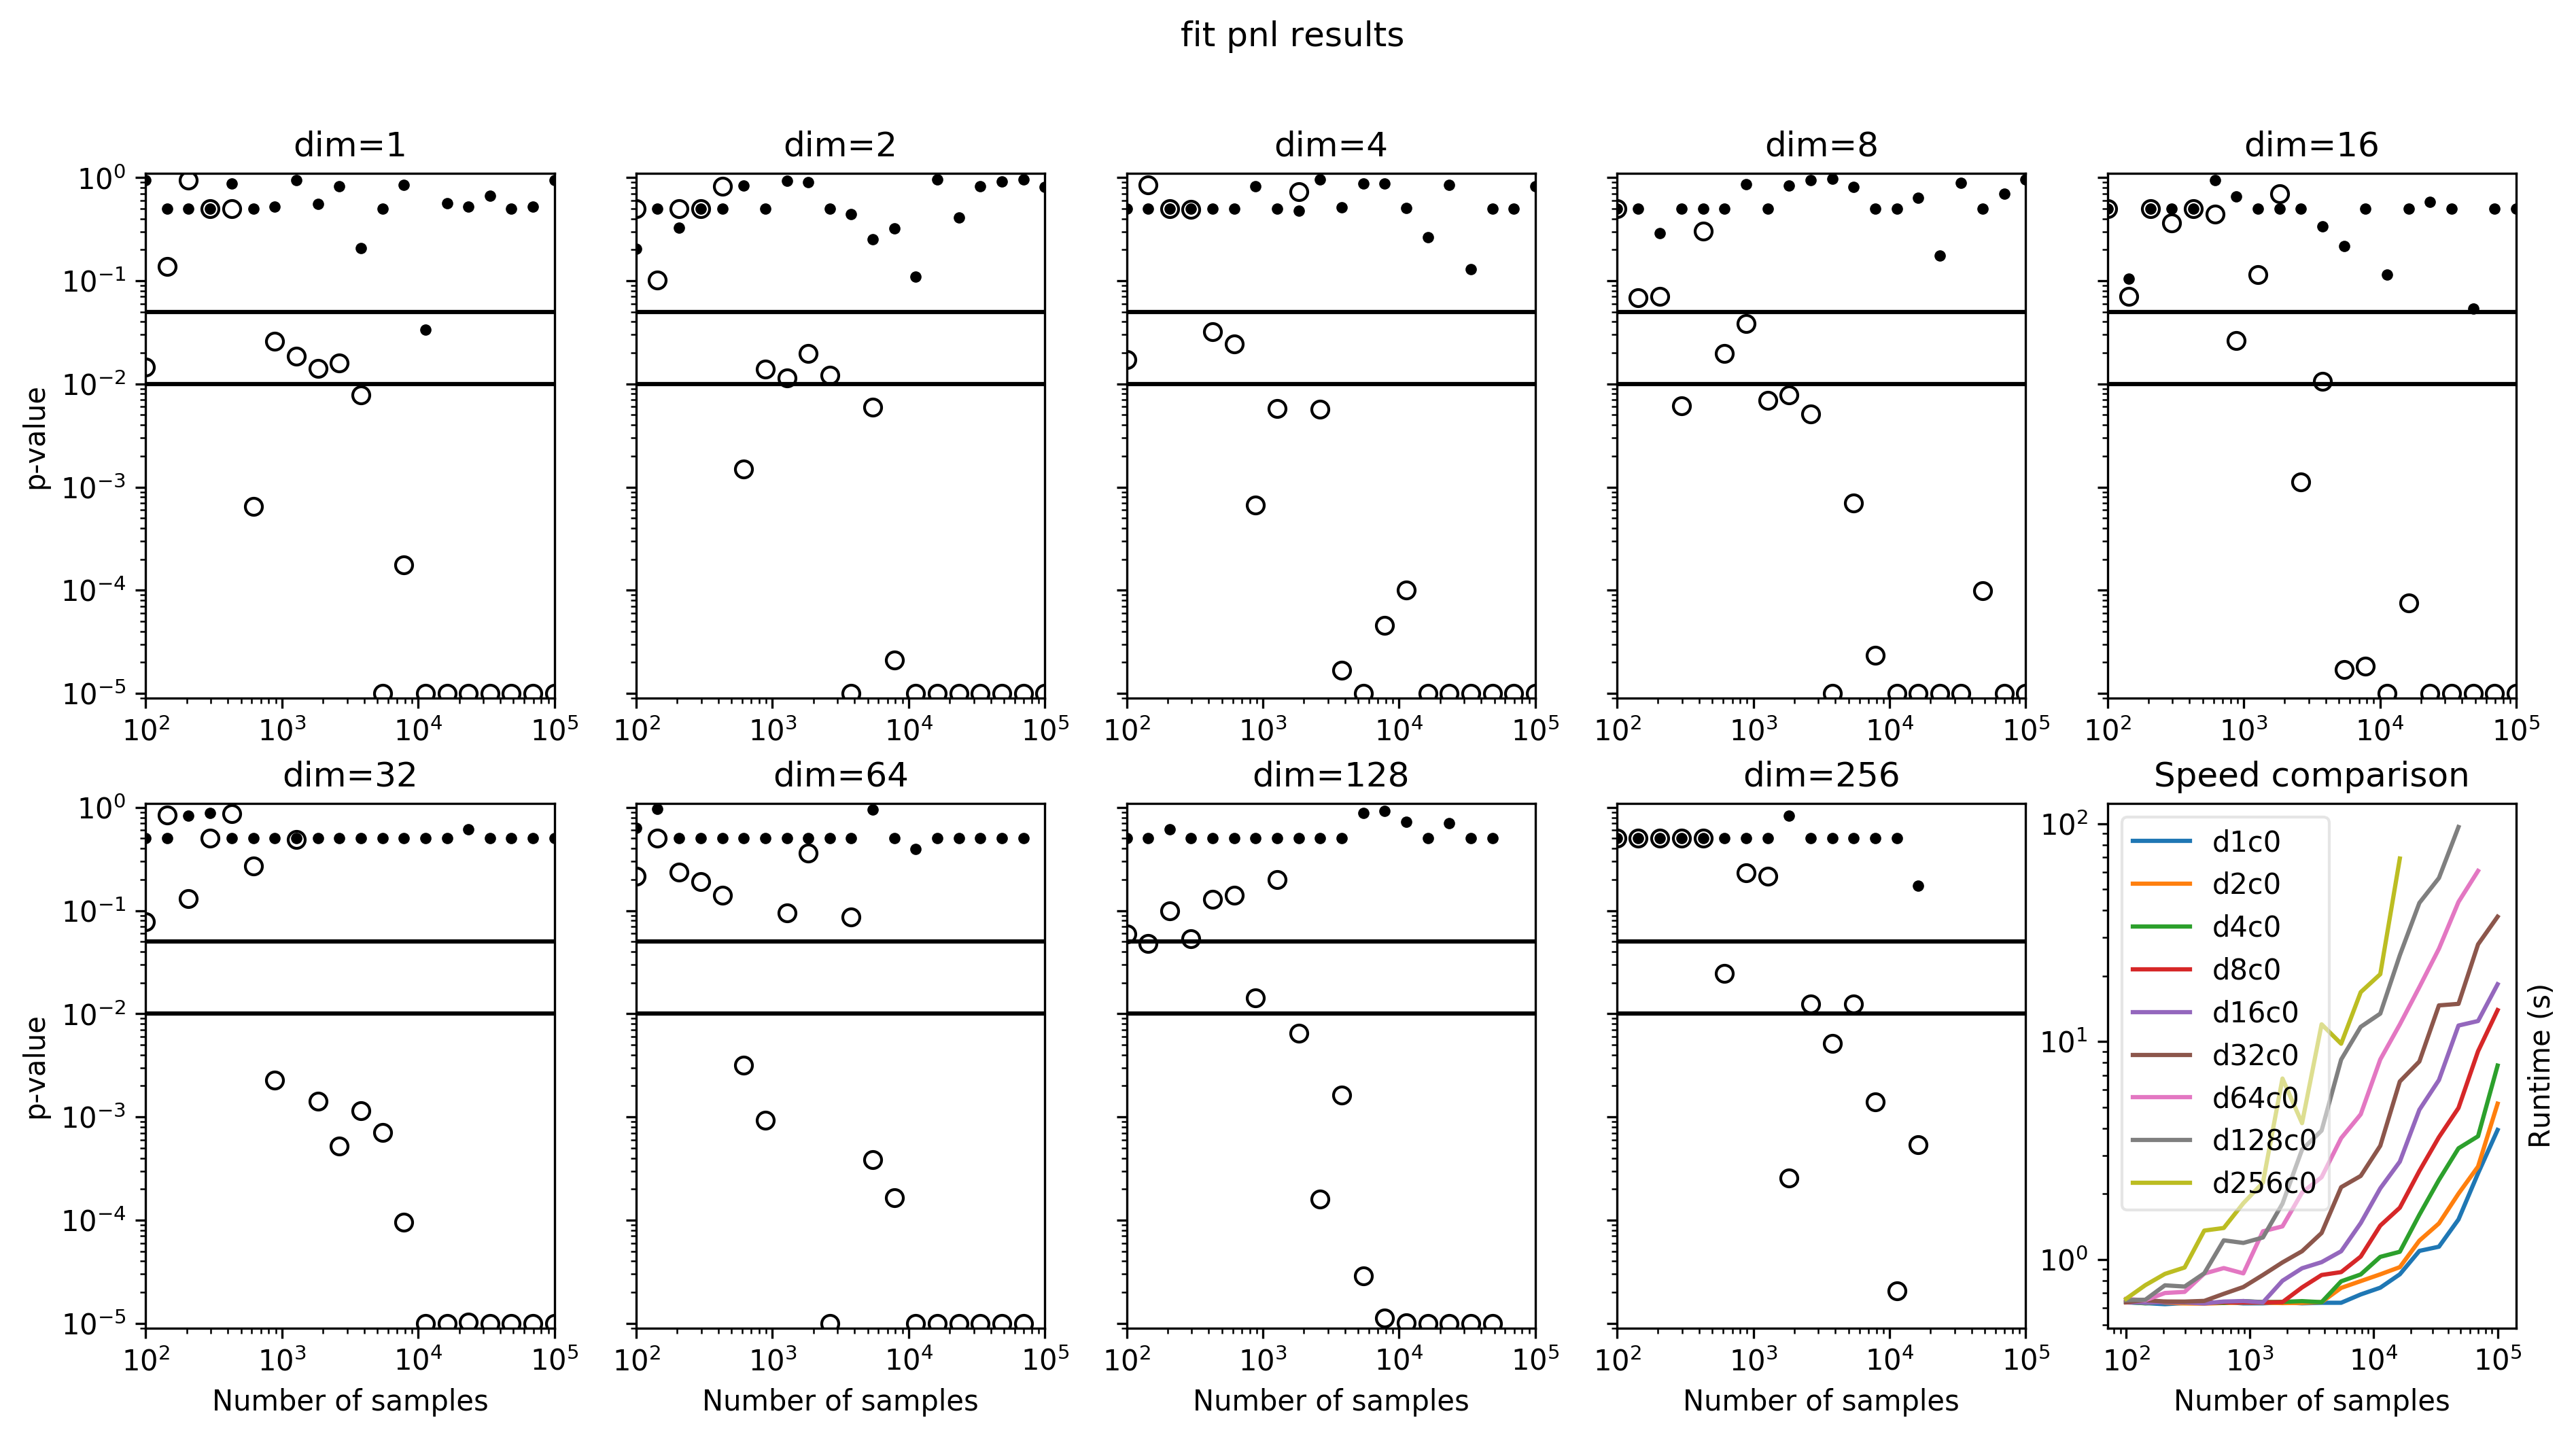

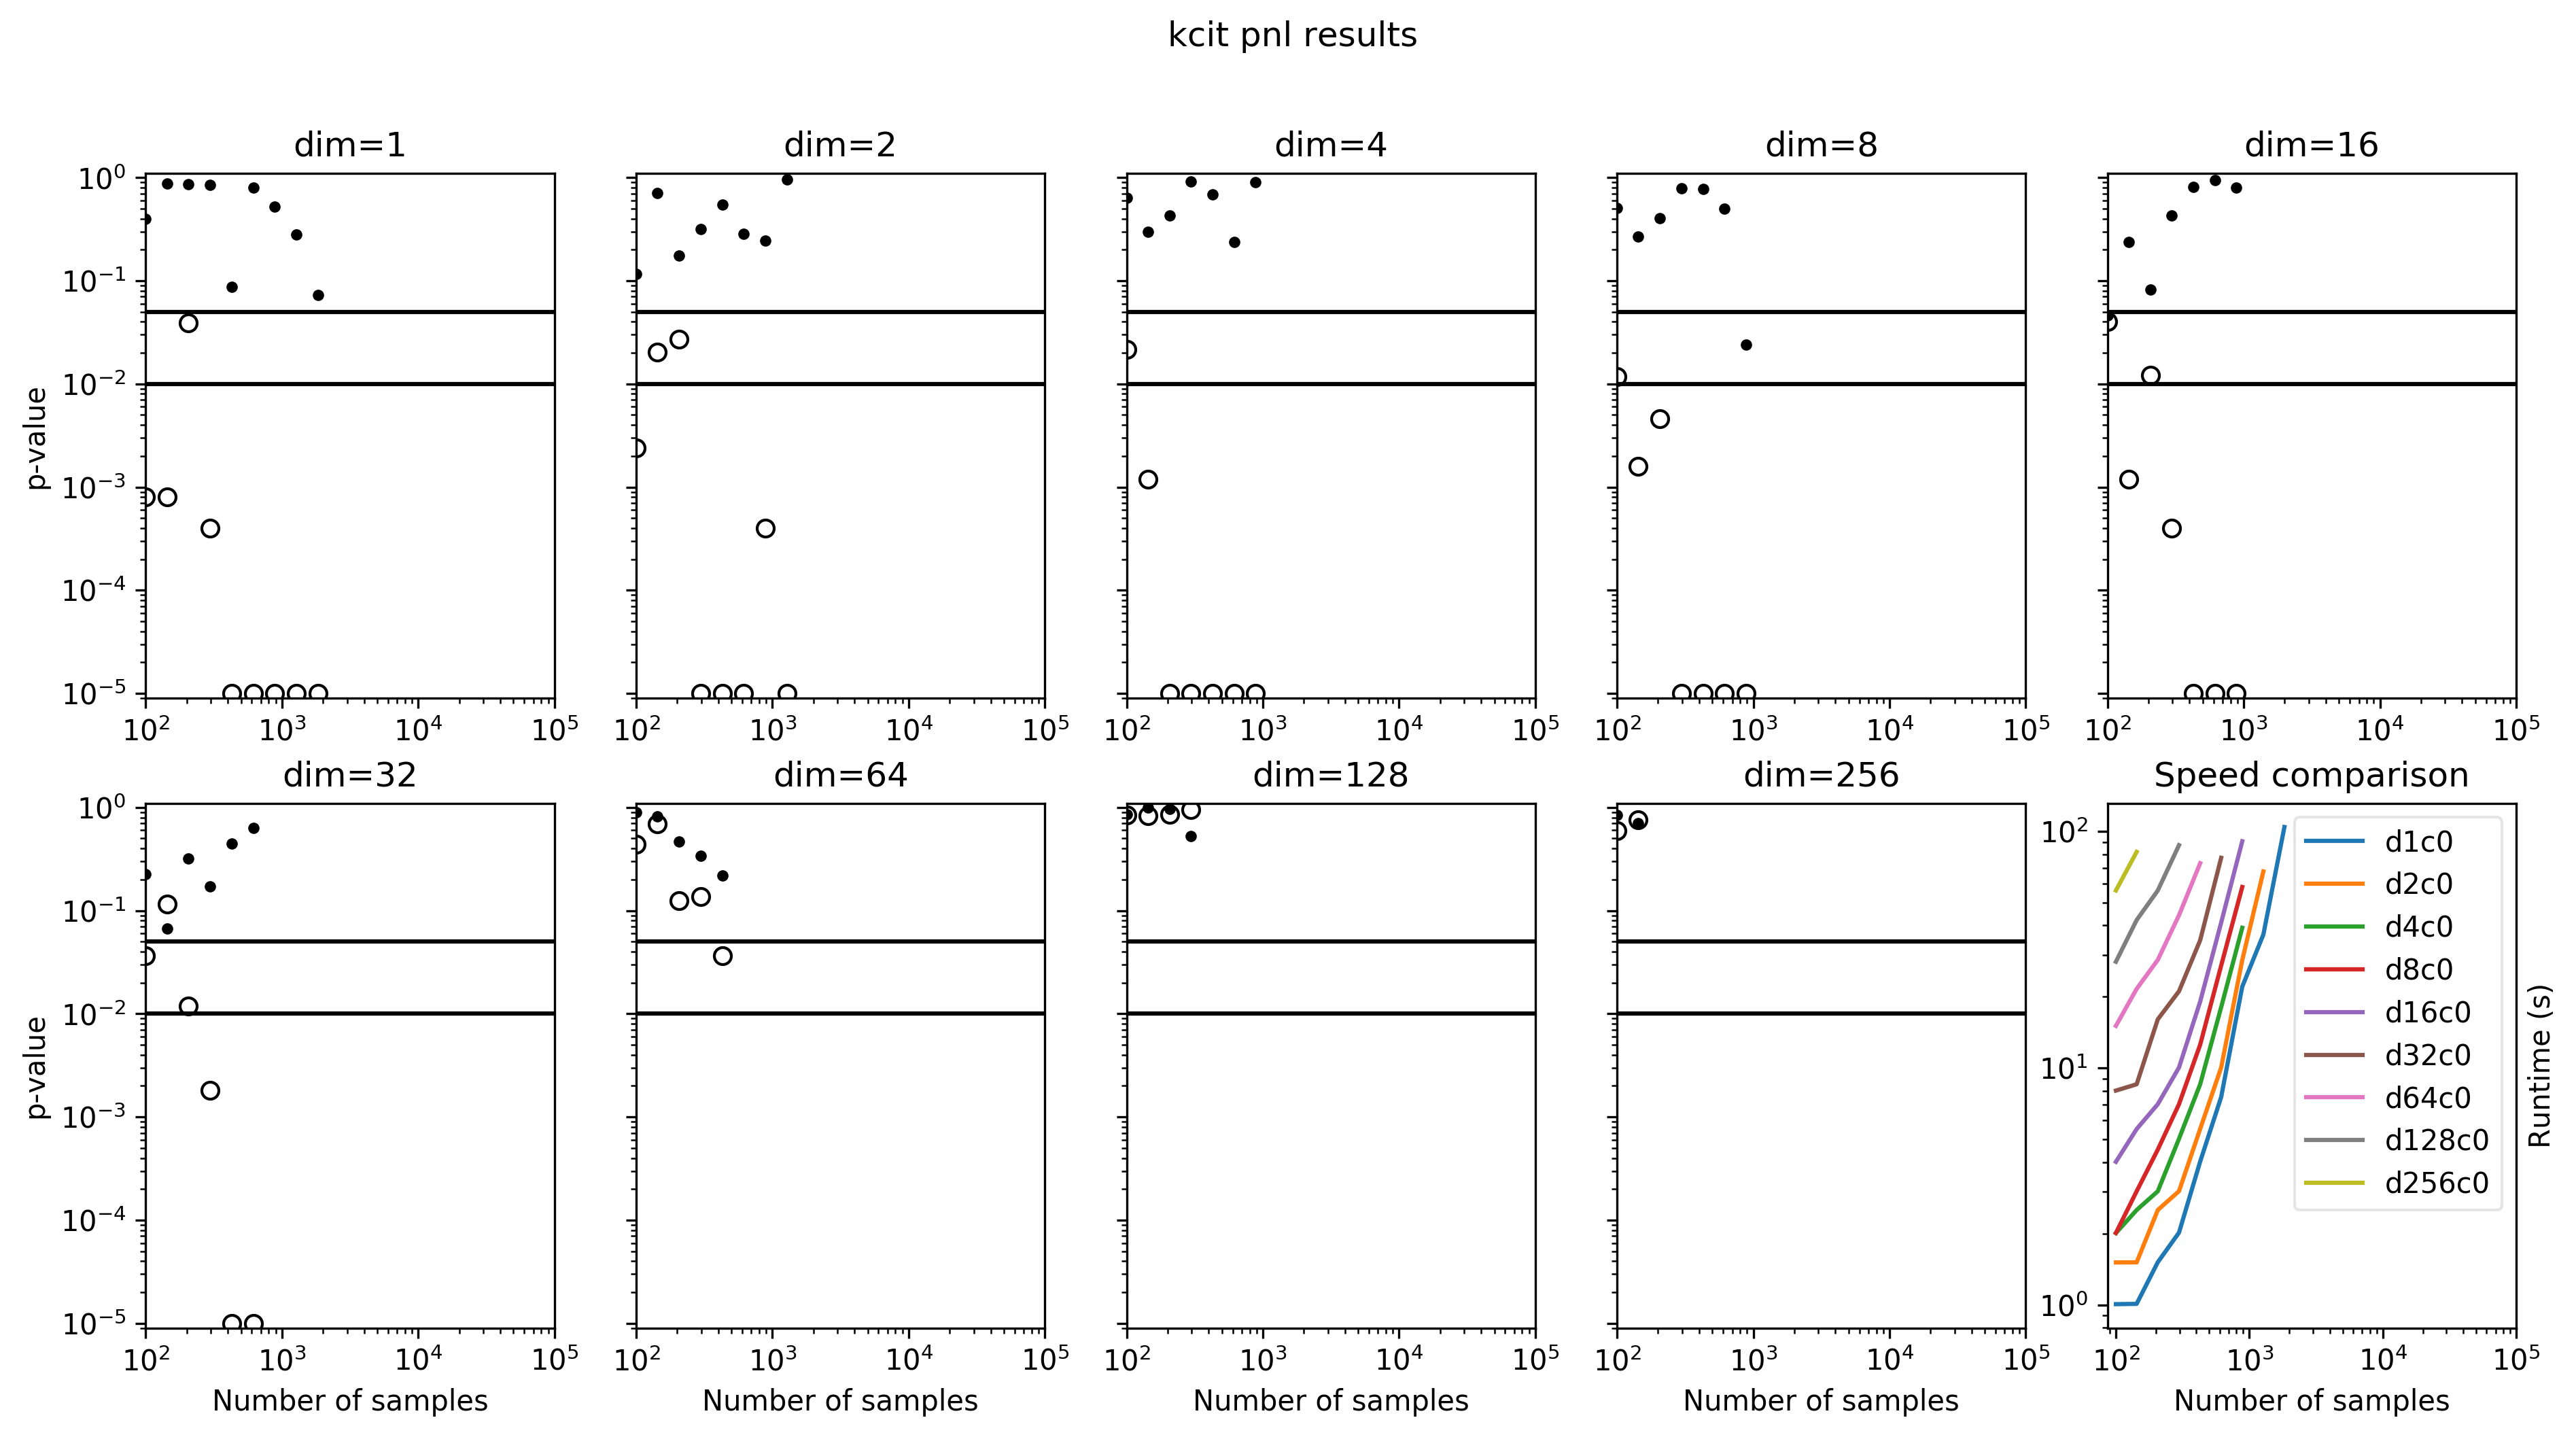

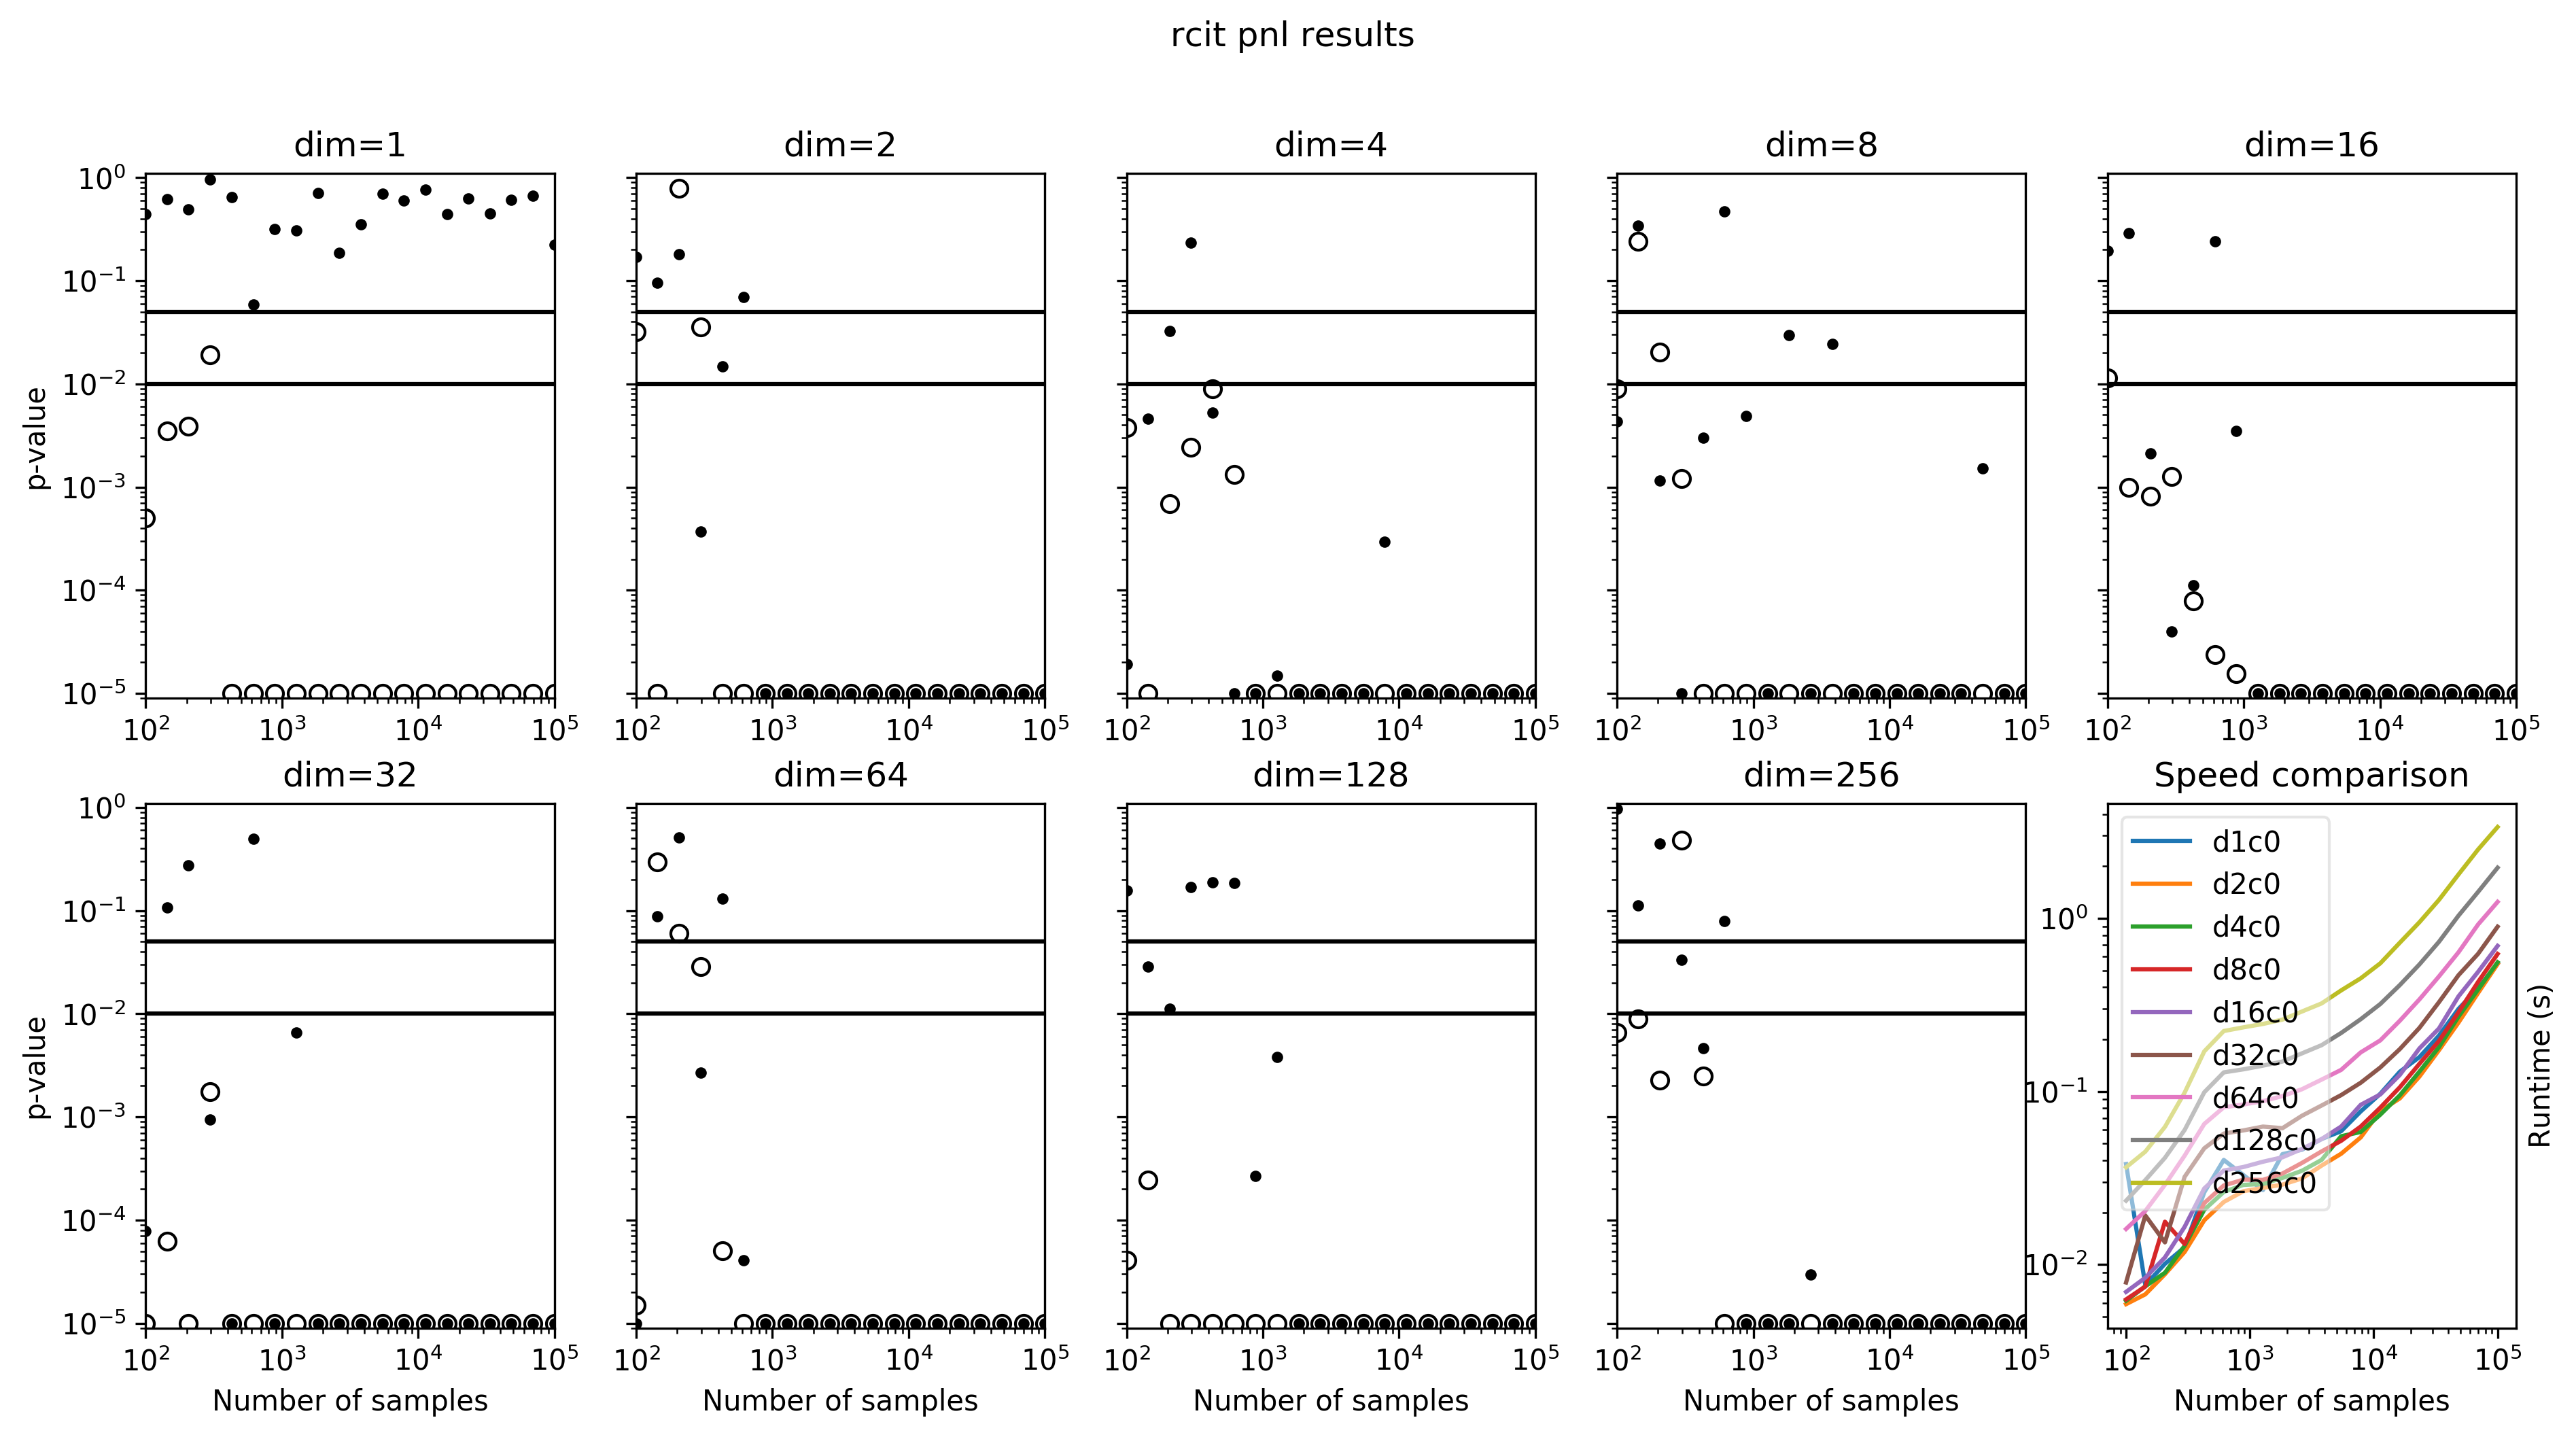

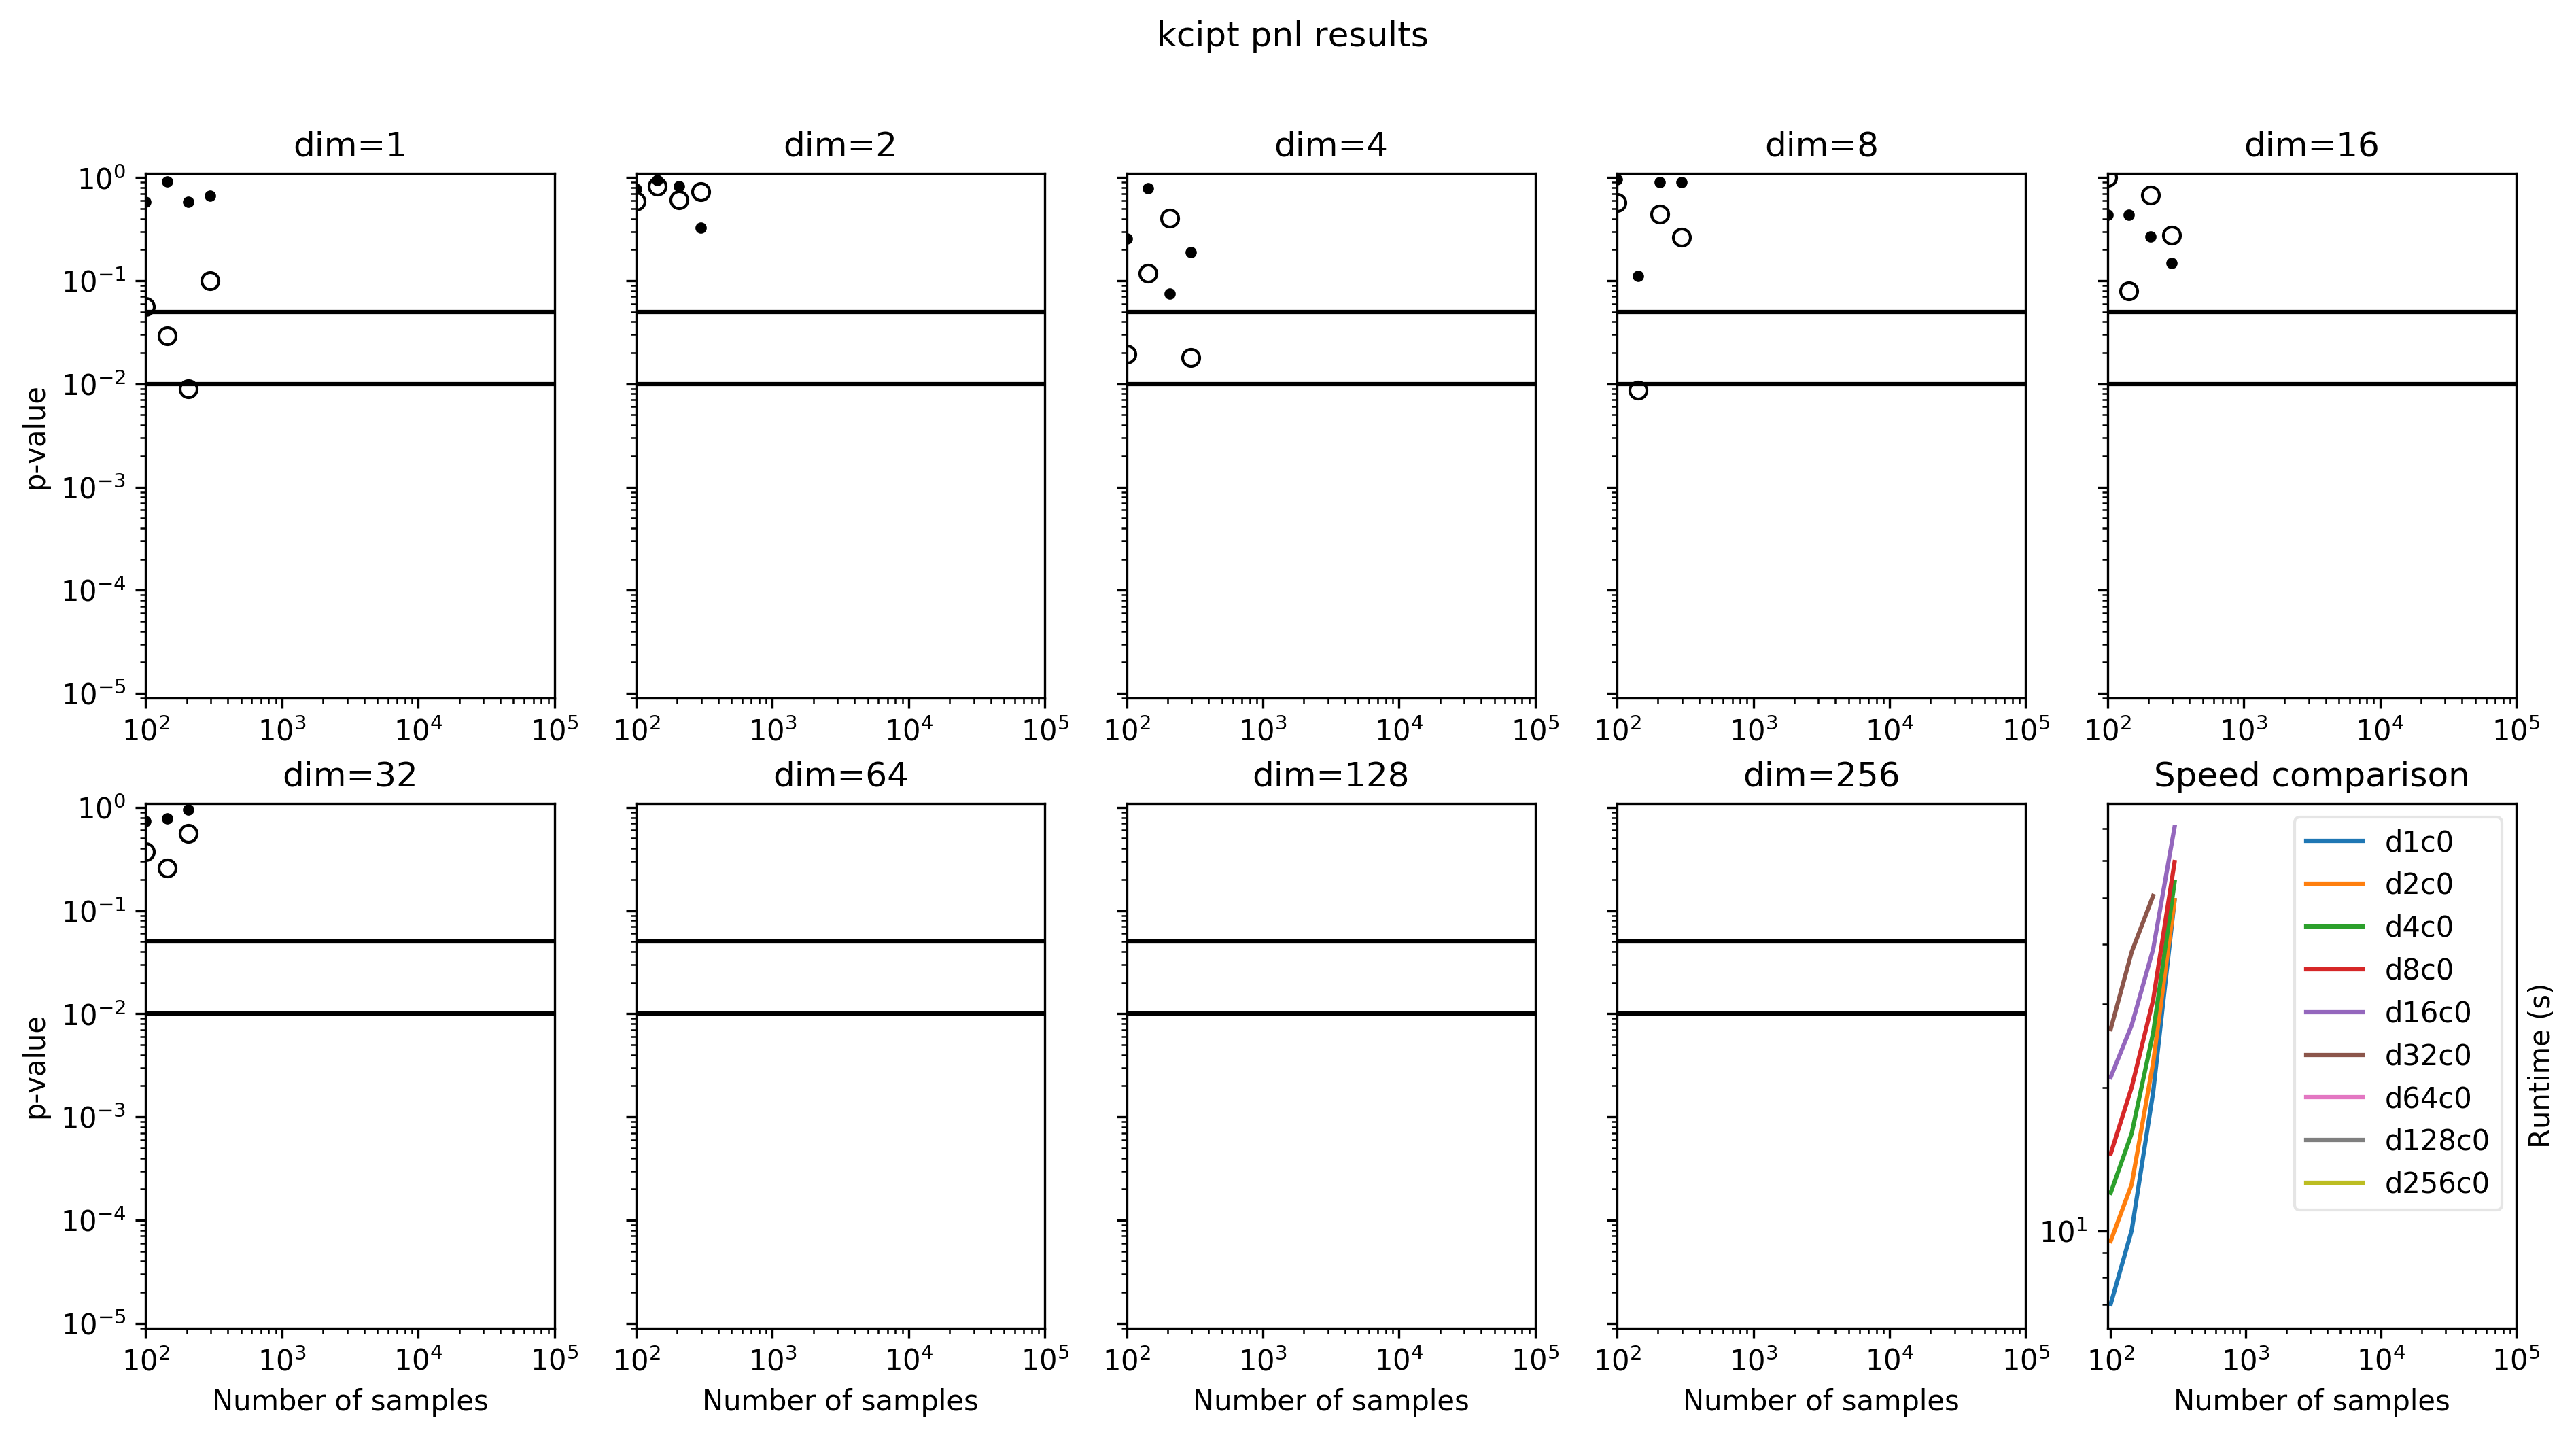

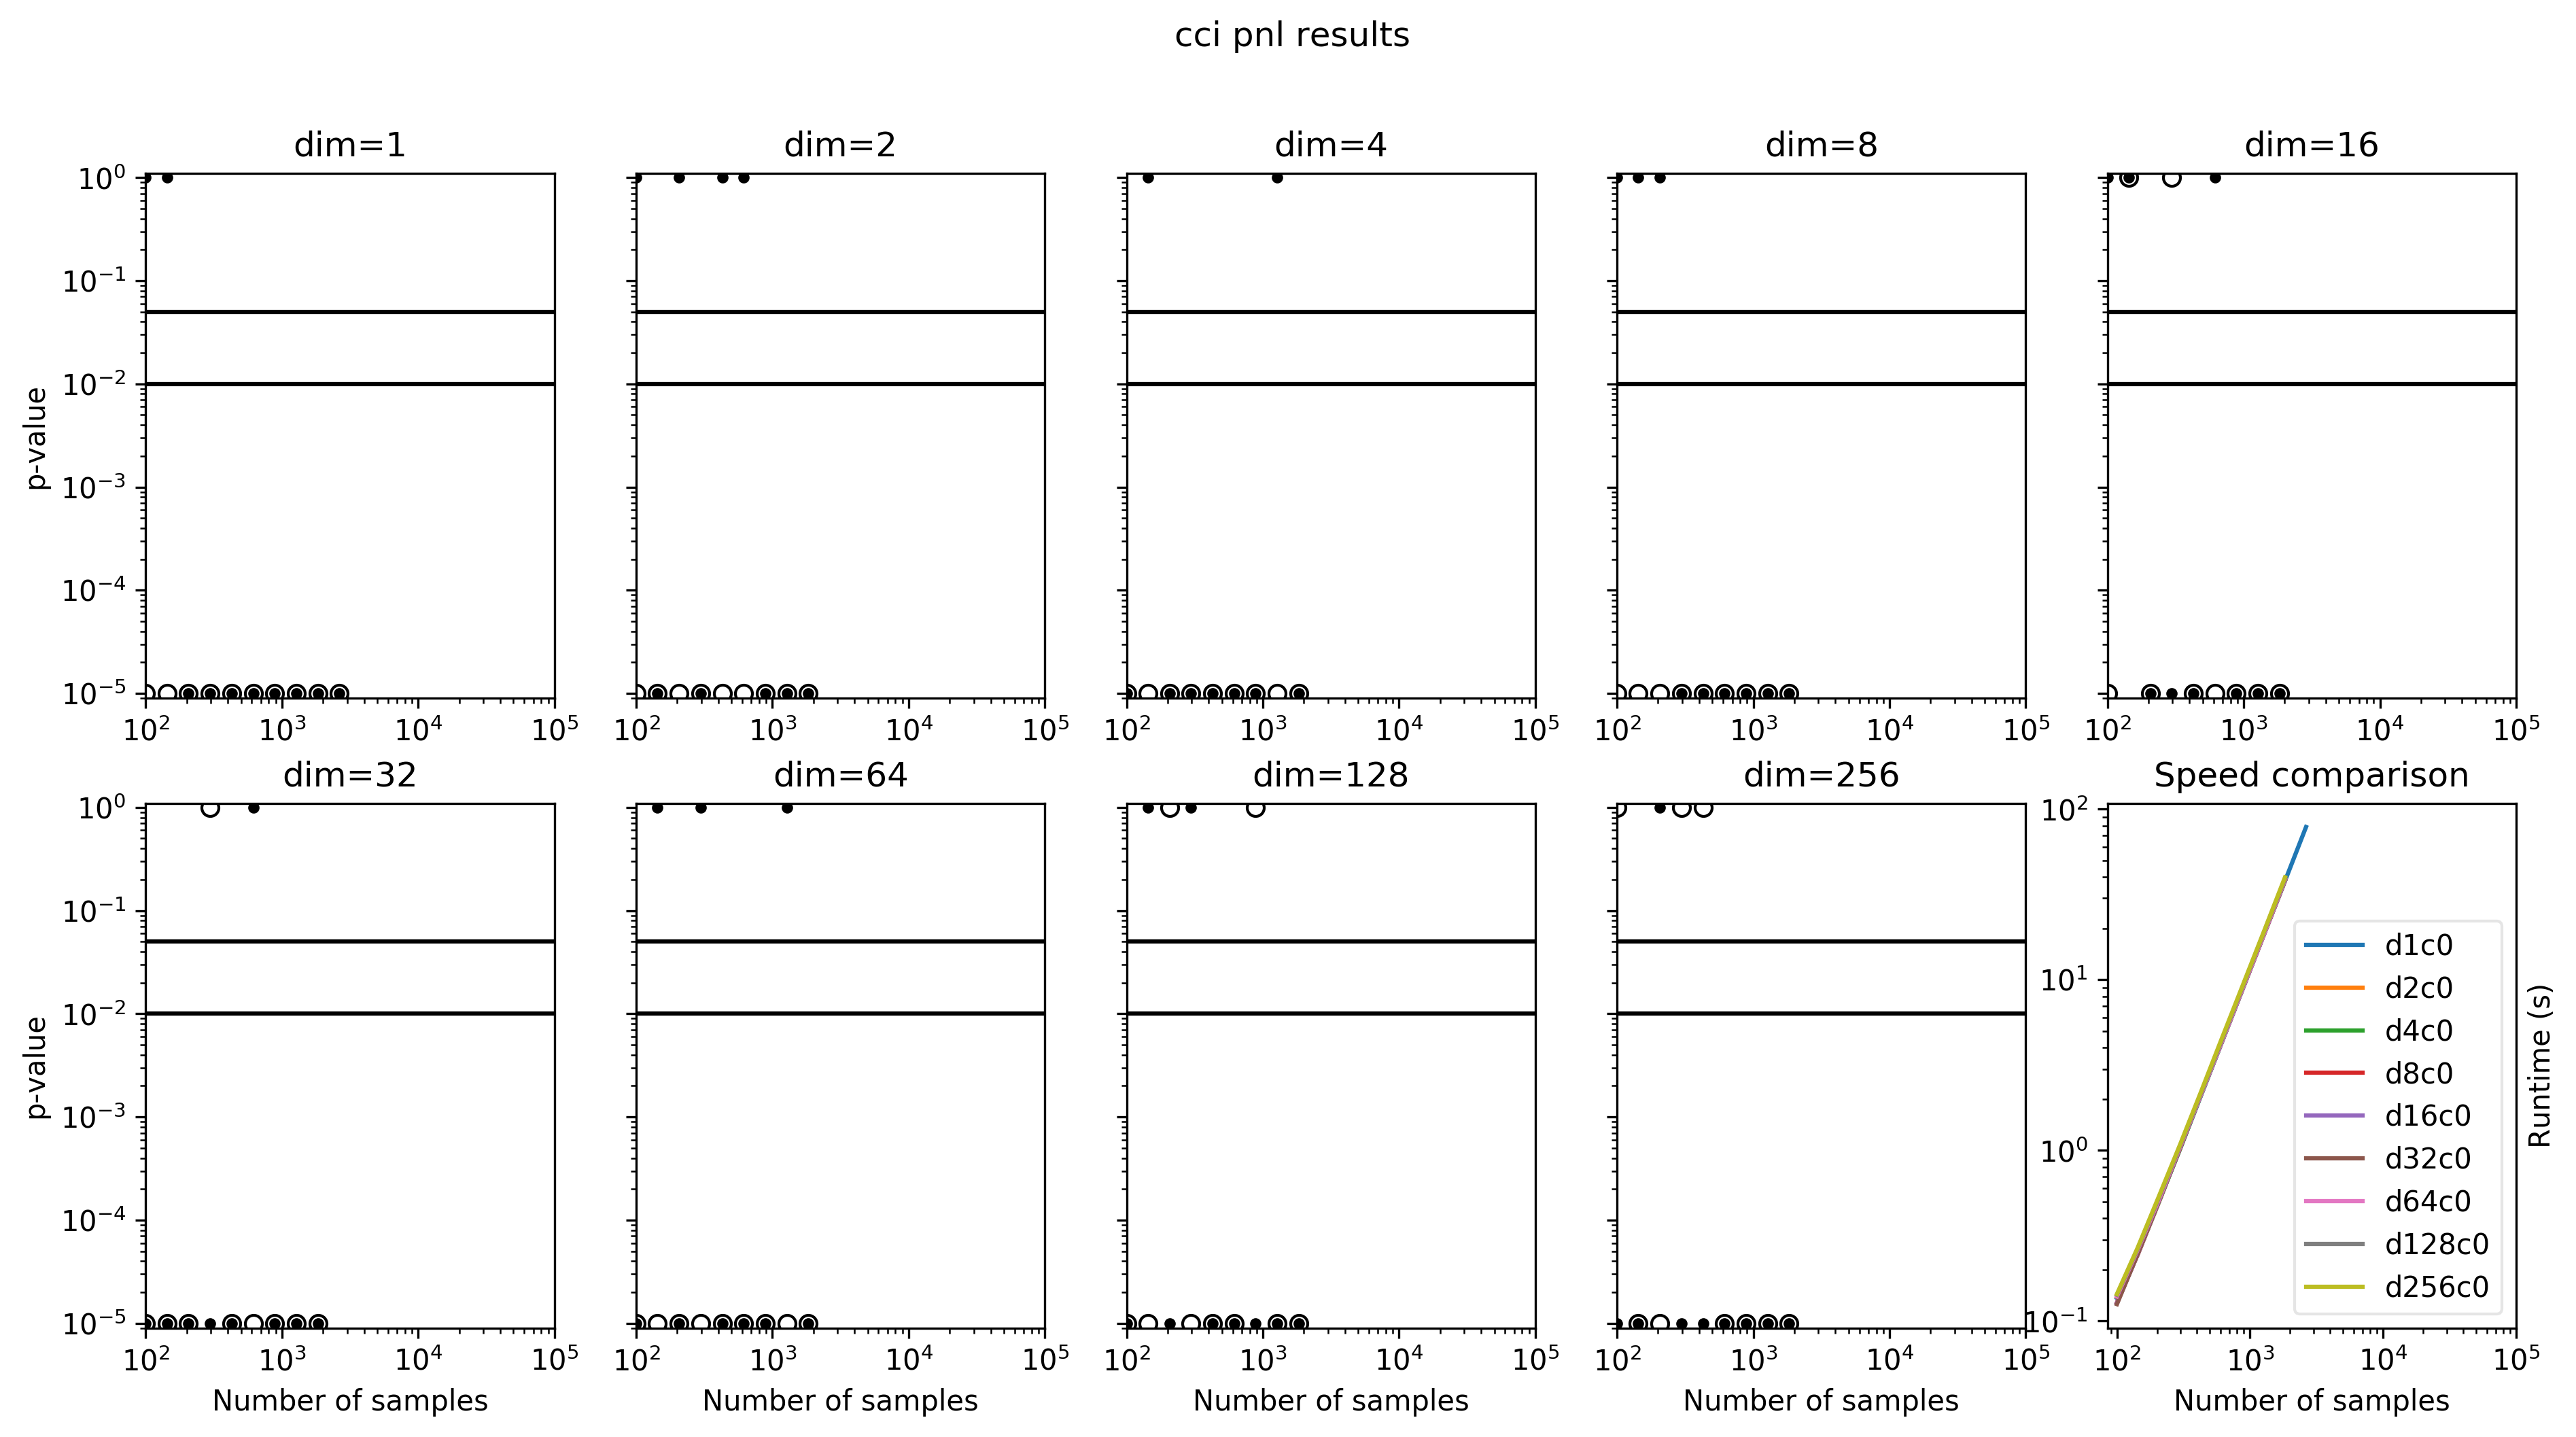

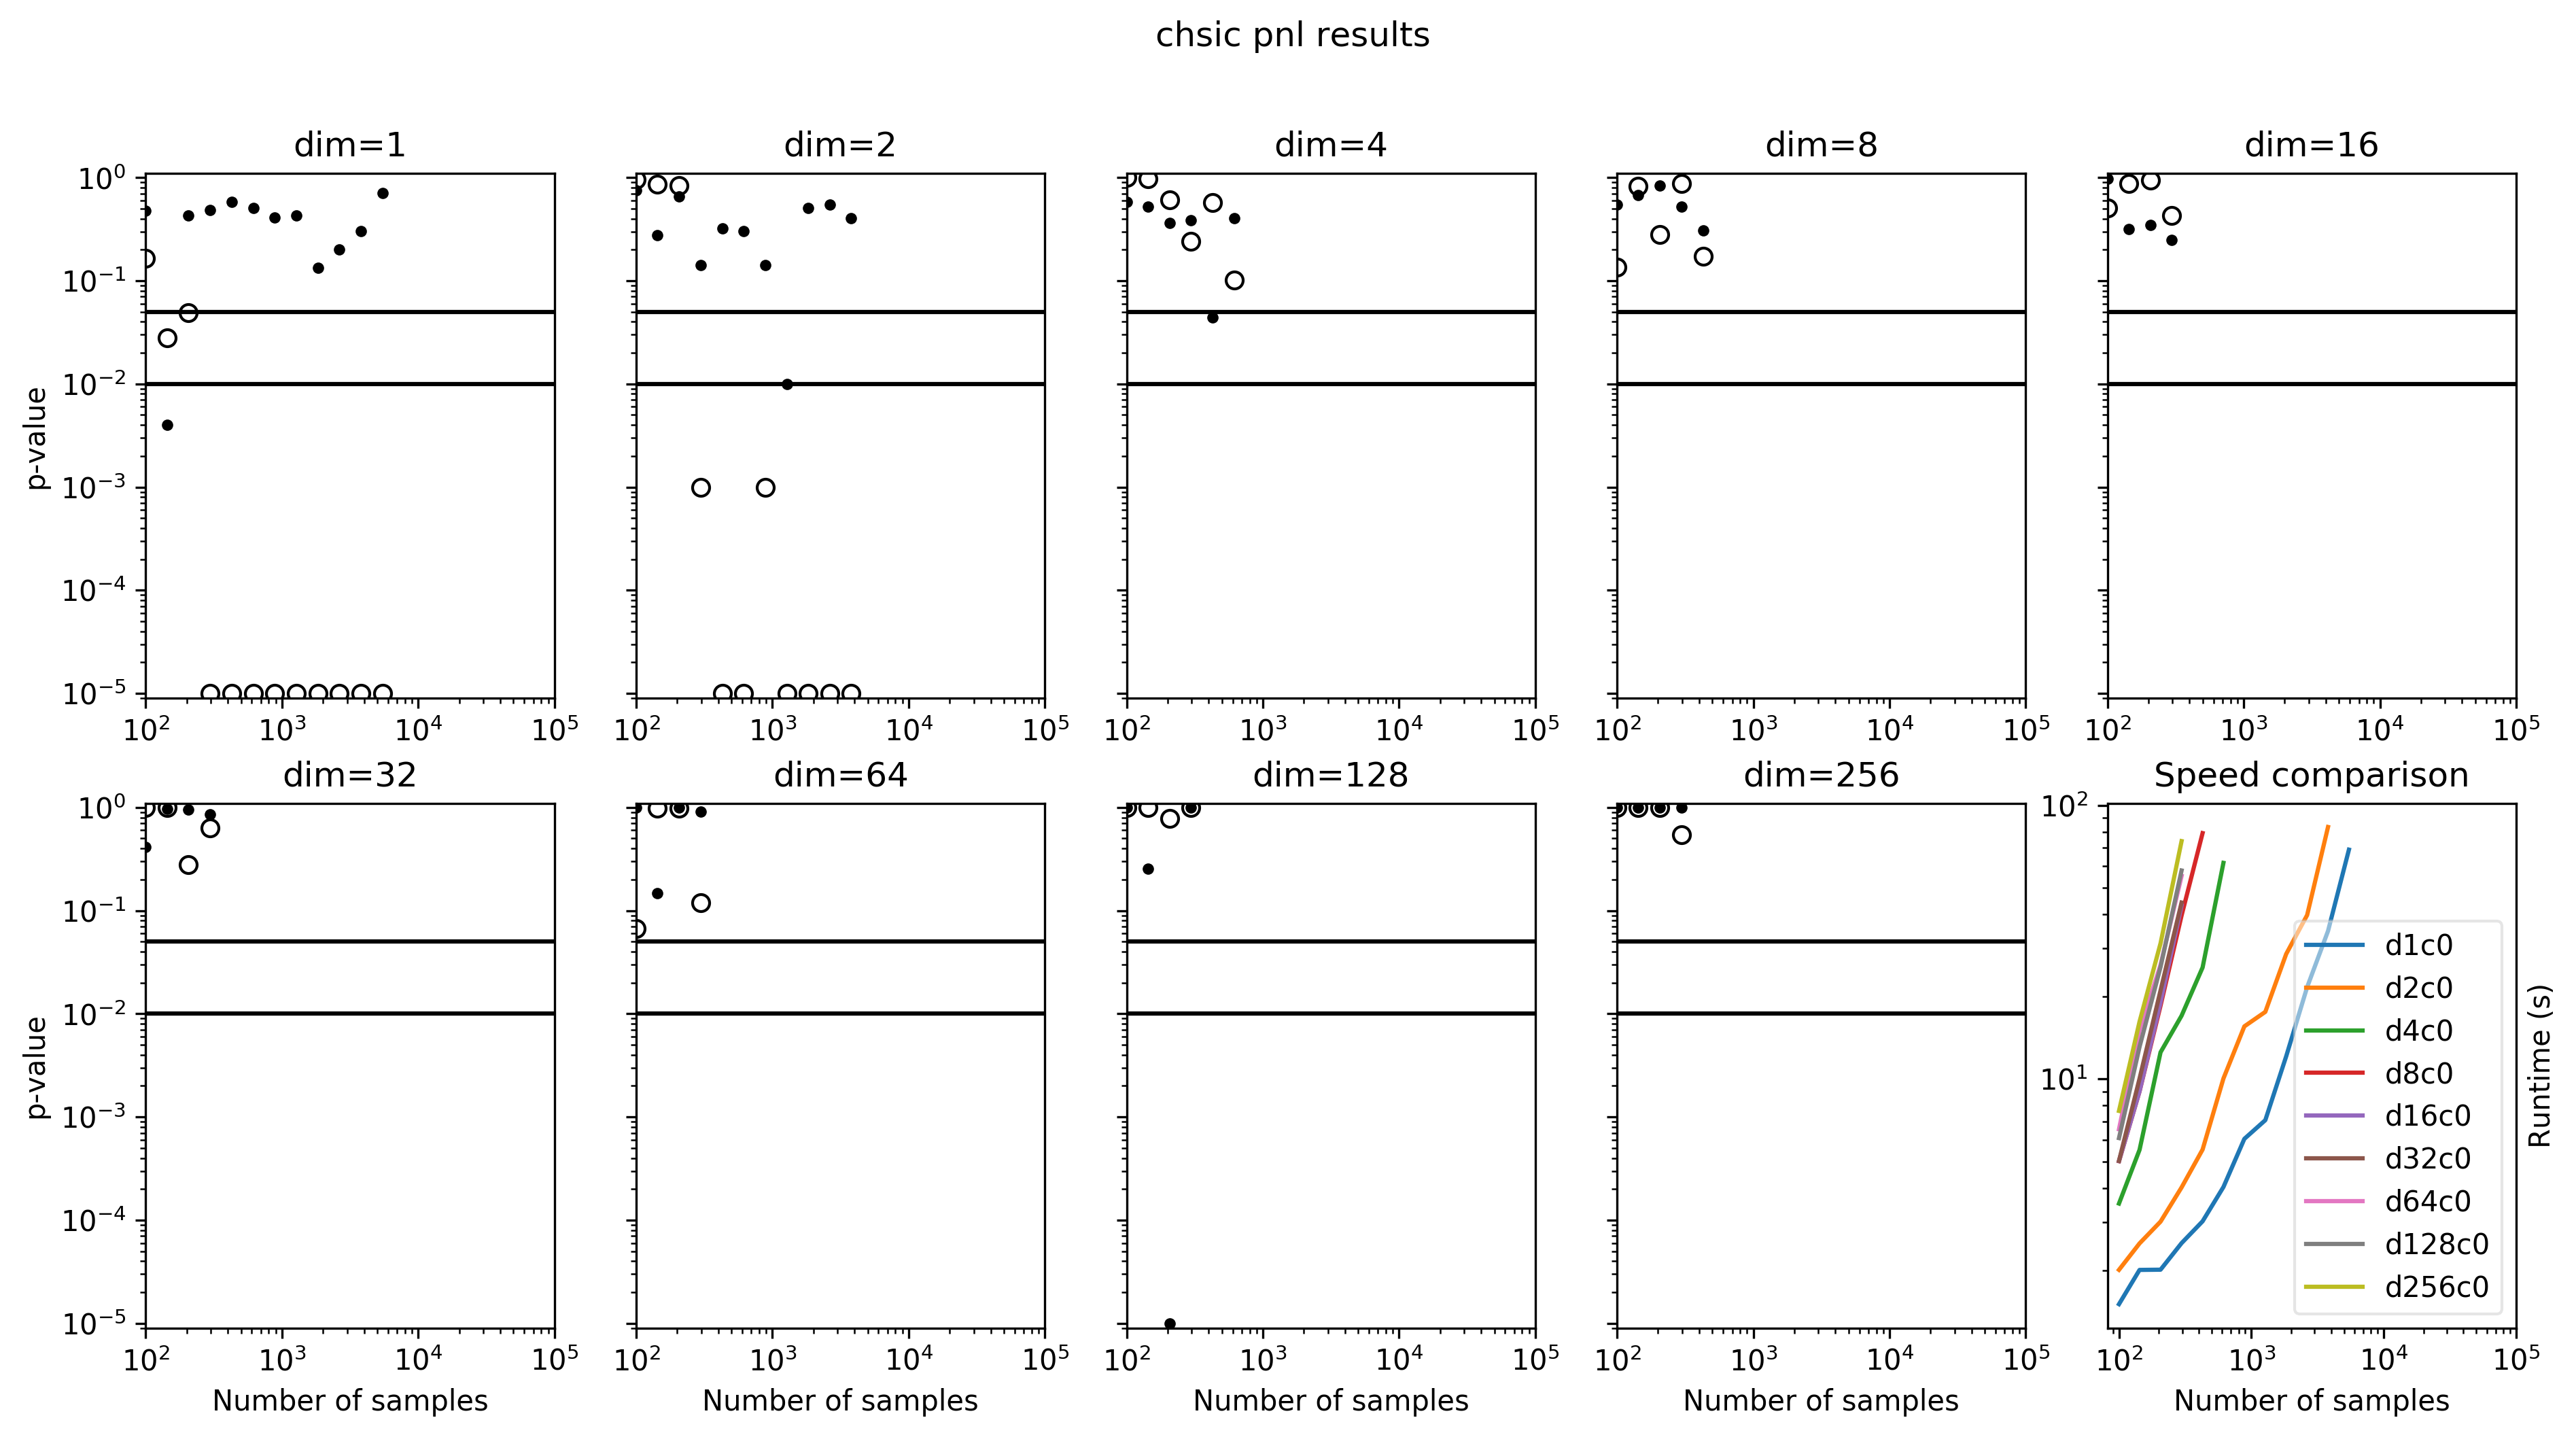

In [71]:
for mthd in ['fit', 'kcit', 'rcit', 'kcipt', 'cci', 'chsic']:
    plot('chain', mthd, save_prefix='../arxiv/figures/fullres_', time_limit=60)

In [64]:
def plot(DSET, method, save_prefix=None, time_limit=60):
    mthd = method
    complexities = ecs.DSETS[DSET][1]
    dims = ecs.DSETS[DSET][2]
    res = joblib.load('../saved_data/{}/{}.pkl'.format(DSET, method))
    top_nsamples = {}
    
    plt.figure(facecolor='white', figsize=(15, 7.5), dpi=300)
    for plt_id, (dim, compl) in enumerate(itertools.product(dims, complexities)):
        print('dim {} compl {}'.format(dim, compl))
        pvals_d = []
        pvals_i = []
        times = []
        for n_samples in ns:
            key = '{}_{}_120mt_{}samples_{}dim_{}complexity'.format(
                        method, DSET, n_samples, dim, compl)
            time = res[key][0][2]
            pvald = res[key][0][0]
            pvali = res[key][0][1]

            if pvald < 0 or pvali < 0:
                time = np.nan # pvals smaller than 0 indicate out of time or Matlab errors.
                
            pvald = max(1e-5, pvald if not np.isnan(pvald) else .5)
            pvali = max(1e-5, pvali if not np.isnan(pvali) else .5)
            pvals_d.append(pvald)
            pvals_i.append(pvali)
            times.append(time)
        pvals_d = np.array(pvals_d)
        pvals_i = np.array(pvals_i)
        times = np.array(times) / 2 # Divide 'times' by 2, to get the avg of the pvali and pvald time.
        pvals_d[np.where(np.isnan(times))[0]] = np.nan
        pvals_i[np.where(np.isnan(times))[0]] = np.nan
        
        if (times <= time_limit).sum() > 0:
            top_nsamples[(dim, compl)] = ns[times <= time_limit][-1]
        else:
            top_nsamples[(dim, compl)] = -1


        plt.suptitle('{} {} results'.format(mthd, 'lingauss' if DSET=='chain' else DSET))
        plt.subplot(2, 5, plt_id+1)
        #plt.title('dim={}, comp={}'.format(dim, compl))
        if DSET in ['pnl', 'chain']:
            plt.title('dim={}'.format(dim))
        if DSET == 'discrete':
            plt.title('states={}, trials={}'.format(dim, compl))
        if DSET == 'chaos':
            plt.title('alpha={}'.format(compl))

        plt.xlim([ns[0], ns[-1]])
        plt.plot(ns, pvals_d, 'ko', label = 'indep', markerfacecolor='none', markeredgecolor='black', markersize=6)
        plt.plot(ns, pvals_i, 'ko', label = 'dep', markeredgecolor='none', markersize=4)
        plt.hlines(.05, 0, 10**6)
        plt.hlines(.01, 0, 10**6)

        plt.yscale('log')
        plt.ylim([1e-5-1e-6, 1.1])
        plt.xscale('log')
        if plt_id == 0 or plt_id == 5:
            plt.ylabel('p-value')
            plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
        else:
            plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], [])
        if plt_id >= 5:
            plt.xticks([1e2, 1e3, 1e4, 1e5])
            plt.xlabel('Number of samples')
        else:
            plt.xticks([1e2, 1e3, 1e4, 1e5])


        ax=plt.subplot(2, 5, 10)
        plt.title('Speed comparison')
        try:
            plt.plot(ns, times, label='d{}c{}'.format(dim, compl))
            plt.yscale('log')
            plt.xscale('log')
            plt.xlabel('Number of samples')
            plt.ylabel('Runtime (s)')
            ax.yaxis.set_label_position("right")
            legend = ax.legend(loc='best', ncol=1)
            legend.get_frame().set_alpha(.5)
            plt.xticks([1e2, 1e3, 1e4, 1e5])
            plt.xlabel('Number of samples')


        except IndexError:
            pass
    np.save(open('../saved_data/{}/{}_top_nsamples'.format(DSET, method), 'w'), top_nsamples)
    if save_prefix is not None:
        plt.savefig('{}_{}_{}.png'.format(save_prefix, DSET, method))